In [1]:
import pandas as pd
from itertools import chain
from datetime import datetime
import praw
from praw.models import MoreComments
import matplotlib.pyplot as plt
%matplotlib inline
from wordcloud import WordCloud, STOPWORDS
import numpy as np
from alpha_vantage.timeseries import TimeSeries

In [2]:
stock = 'GME'

In [3]:
#Pull GME Price Data
ts = TimeSeries(key='key', output_format='pandas')
stock_data, meta_data = ts.get_daily(symbol=stock, outputsize='compact')
stock_df = stock_data['4. close']
stocks_df = stock_df.loc[:'2022-02-22']

In [4]:
reddit = praw.Reddit(
    client_id="client_id",
    client_secret="client_secret",
    password="password",
    user_agent="sentiment_analysis",
    username="username")
reddit.read_only=True

In [5]:
sub = reddit.subreddit("wallstreetbets")
#create list of posts using search criteria 
post_list = []
for submission in sub.search('flair:"Daily Discussion"', 'time_filter:"week"'):
    if "Daily Discussion Thread" in submission.title and "February" in submission.title:
        post_list.append(submission)
    if "Daily Discussion Thread" in submission.title and "March" in submission.title:
        post_list.append(submission)      
    
#convert list to dataframe
post_df = pd.DataFrame([datetime.fromtimestamp(p.created).date().strftime('%Y-%m-%d'), p.title, p.id, p] for p in post_list)
post_df.columns=("Date", "Title", "ID", "Submission")

In [ ]:
x = post_df["Date"] >= "2022-02-22"
post1_df = post_df.loc[x]
post1_df.reset_index(drop=True, inplace=True)
post1_df['Date'] = post1_df['Date'].astype('datetime64[ns]')
#post1_df.info()
post1_df

In [7]:
#Import sentiment anlysis ML tool
from transformers import pipeline
sentiment_analysis = pipeline("sentiment-analysis")

In [8]:
#run sentiment analysis for each post
daily_sen_list = []
for i, j in post1_df.iterrows():
    comment_list = []
    for top_level_comment in j["Submission"].comments:
        if isinstance(top_level_comment, MoreComments):
            continue
        post = {}
        post['Author'] = top_level_comment.author
        post['Comment'] = top_level_comment.body
        comment_list.append(post)
    comment_df = pd.DataFrame(comment_list)
    
    gme_filter = comment_df['Comment'].str.contains(stock, case=False)
    gme_df = comment_df[gme_filter]

    sen_list = []
    for i in gme_df['Comment']:
        result = sentiment_analysis(i)
        sen_list.append(result)
        
    sen_df = pd.DataFrame(list(chain.from_iterable(sen_list)))
    sen_neg = ((sen_df.label == 'NEGATIVE').sum()/(sen_df.label.count()))
    sen_pos = ((sen_df.label == 'POSITIVE').sum()/(sen_df.label.count()))
    
    sen_data = (j["Date"], sen_neg, sen_pos)
    daily_sen_list.append(sen_data)
    print(sen_data)

(Timestamp('2021-02-25 00:00:00'), 0.84, 0.16)
(Timestamp('2021-03-08 00:00:00'), 0.7652173913043478, 0.23478260869565218)
(Timestamp('2021-03-04 00:00:00'), 0.75, 0.25)
(Timestamp('2021-03-03 00:00:00'), 0.8235294117647058, 0.17647058823529413)
(Timestamp('2021-03-02 00:00:00'), 0.8395904436860068, 0.16040955631399317)
(Timestamp('2021-03-05 00:00:00'), 0.7727272727272727, 0.22727272727272727)
(Timestamp('2021-03-09 00:00:00'), 0.7297297297297297, 0.2702702702702703)
(Timestamp('2021-02-26 00:00:00'), 0.782608695652174, 0.21739130434782608)
(Timestamp('2021-03-01 00:00:00'), 0.7435897435897436, 0.2564102564102564)
(Timestamp('2021-02-24 00:00:00'), 0.7474747474747475, 0.25252525252525254)
(Timestamp('2021-02-23 00:00:00'), 0.7692307692307693, 0.23076923076923078)
(Timestamp('2021-02-22 00:00:00'), 0.9, 0.1)


In [9]:
daily_sen_df = pd.DataFrame(daily_sen_list, columns = ['Date1', 'Negative', 'Positive'])

new_df = pd.concat([post1_df, daily_sen_df], axis=1)
new_df = new_df.drop('Date1', axis=1)
new_df = new_df.set_index('Date')

In [10]:
stopwords = set(STOPWORDS)
stopwords.update(["br", "href"])
textt = " ".join(comment for comment in gme_df.Comment)
wordcloud = WordCloud(stopwords=stopwords,min_word_length=3).generate(textt)

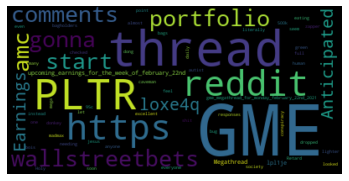

In [11]:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [12]:
#Combine both dataframes
combined_df = pd.concat([new_df, stocks_df], axis=1)
combined_df.rename(columns={'4. close':'Price'}, inplace=True)
combined_df

,Title,ID,Submission,Negative,Positive,Price
2021-02-22,"Daily Discussion Thread for February 22, 2021",lplby9,lplby9,0.900000,0.100000,46.00
2021-02-23,"Daily Discussion Thread for February 23, 2021",lqfr4s,lqfr4s,0.769231,0.230769,44.97
2021-02-24,"Daily Discussion Thread for February 24, 2021",lra5cg,lra5cg,0.747475,0.252525,91.71
2021-02-25,"Daily Discussion Thread for February 25, 2021",ls42x6,ls42x6,0.840000,0.160000,108.73
2021-02-26,"Daily Discussion Thread for February 26, 2021",lsvesi,lsvesi,0.782609,0.217391,101.74
2021-03-01,"Daily Discussion Thread for March 01, 2021",lv6dsz,lv6dsz,0.743590,0.256410,120.40
2021-03-02,"Daily Discussion Thread for March 02, 2021",lvzh9h,lvzh9h,0.839590,0.160410,118.18
2021-03-03,"Daily Discussion Thread for March 03, 2021",lwr7oo,lwr7oo,0.823529,0.176471,124.18
2021-03-04,"Daily Discussion Thread for March 04, 2021",lxi05e,lxi05e,0.750000,0.250000,132.35
2021-03-05,"Daily Discussion Thread for March 05, 2021",ly9gxp,ly9gxp,0.772727,0.227273,137.74


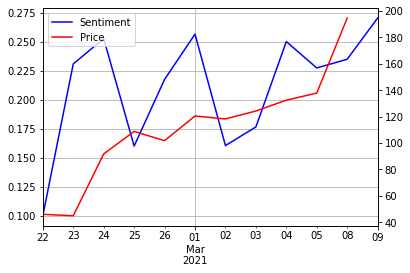

In [13]:
#Plot daily change in sentiment and daily change in stock price
ax1 = combined_df['Positive'].plot(color='blue', grid=True, label='Sentiment')
ax2 = combined_df['Price'].plot(color='red', grid=True, secondary_y=True, label='Price')

h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()

plt.legend(h1+h2, l1+l2, loc=2)
plt.show()